In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as mticker

# Gibbs SeaWater (GSW) Oceanographic Toolbox of TEOS-10. 
import gsw

In [22]:
# retrieve the actual measurements of 
# cond., pres., and temp. from the CTD files,
# includes other values like Salinity (PSS) and Density

# SALINITY and DENSITY are DERIVED PARAMETERS - they are
# calculated for seawater/saline conditions

# WE want to figure out what the density of a freshwater body would look like

total_df = pd.read_csv('../data/total_df.csv') # load in data

# Keystone Cove
KEY_Full = total_df[total_df['Area'] == 'KEY'].copy() # filter by area
KEY_Full['UTC Time'] = pd.to_datetime(KEY_Full['UTC Time'])
KEY_18 = KEY_Full[KEY_Full['UTC Time'].dt.date == pd.to_datetime('2025-05-18').date()]

# Harding Cove
HAR_Full = total_df[total_df['Area'] == 'HAR'].copy()
HAR_Full['UTC Time'] = pd.to_datetime(HAR_Full['UTC Time'])
HAR_17 = HAR_Full[HAR_Full['UTC Time'].dt.date == pd.to_datetime('2025-05-17').date()]

We want to compare the International Equation of State for Seawater, the equation that the CTD used in-house, to an equation that finds density via Total Disolved Solids (TDS) calculation. 

In [23]:
def freshwater_density(T_C, SpC_uScm, alpha=0.25): 
    """
    Estimate freshwater density using temperature and specific conductance.

    Parameters:
    T_C : float or array-like
        Temperature in degrees Celsius
    SpC_uScm : float or array-like
        Specific conductance in µS/cm

    Returns:
    density : float or array-like
        Estimated water density in kg/m^3
    """
    # Pure water density from Chen & Millero (1986)
    rho_0 = (999.842594 + 6.793952e-2 * T_C - 9.095290e-3 * T_C**2 +
             1.001685e-4 * T_C**3 - 1.120083e-6 * T_C**4 + 6.536332e-9 * T_C**5)
    
    # Empirical correction for dissolved ions (TDS effect)
    alpha = alpha / 1000  # kg/m^3 per µS/cm
    delta_rho = alpha * SpC_uScm

    return rho_0 + delta_rho


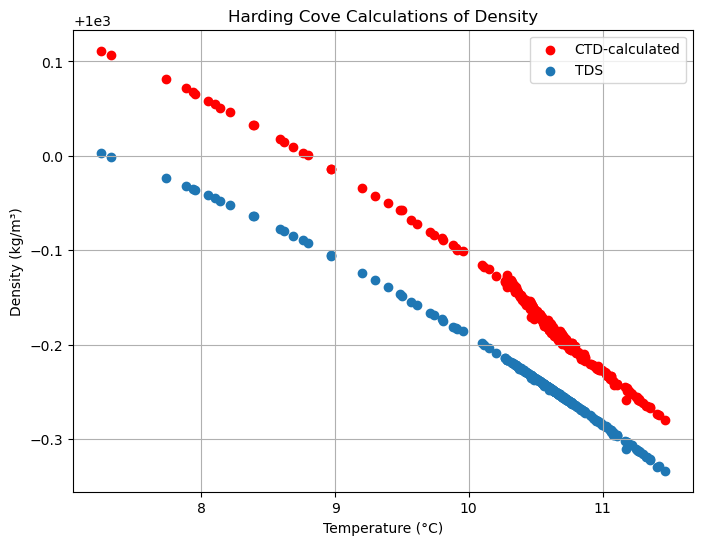

In [24]:
rho = freshwater_density(HAR_17['Temperature (°C)'], HAR_17['Specific Conductance (µS/cm)'])

fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(HAR_17['Temperature (°C)'], HAR_17['Density (kg/m³)'],label='CTD-calculated', c='red')
ax.scatter(HAR_17['Temperature (°C)'], rho, label='TDS')

ax.set_title("Harding Cove Calculations of Density")
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Density (kg/m³)')
plt.legend()
plt.grid(True)
plt.show()

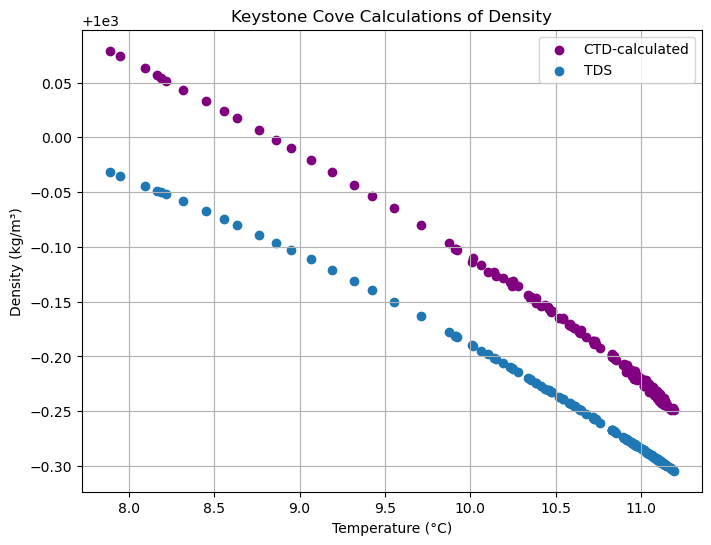

In [25]:
rho = freshwater_density(KEY_18['Temperature (°C)'], KEY_18['Specific Conductance (µS/cm)'])

fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(KEY_18['Temperature (°C)'], KEY_18['Density (kg/m³)'],label='CTD-calculated', c='purple')
ax.scatter(KEY_18['Temperature (°C)'], rho, label='TDS')

ax.set_title("Keystone Cove Calculations of Density")
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Density (kg/m³)')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# typical range of values within the datasets

# temperature (degrees C)
t_vals = np.linspace(7, 12, 100)

# conductivity (microSiemens per centimeter)
c_vals = np.linspace(.284, .314 , 100)

# pressure (decibar)
p_vals = np.linspace(0, 4, 100)

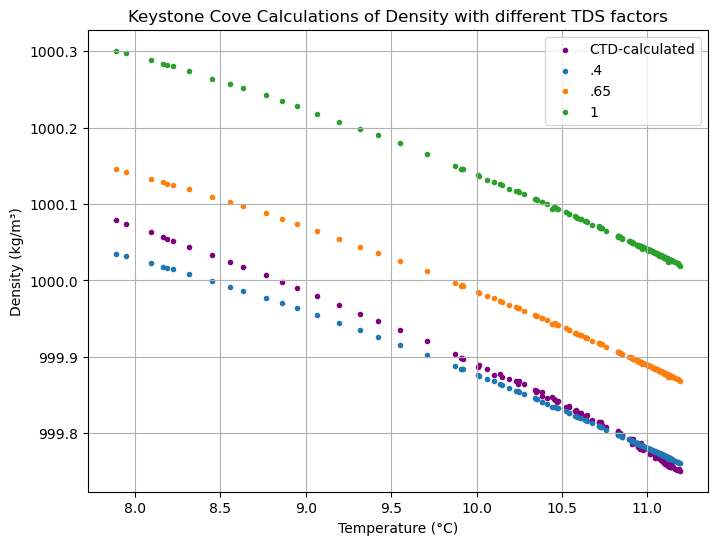

In [28]:
rho_low = freshwater_density(KEY_18['Temperature (°C)'], KEY_18['Specific Conductance (µS/cm)'], .4)
rho_mid = freshwater_density(KEY_18['Temperature (°C)'], KEY_18['Specific Conductance (µS/cm)'], .65)
rho_high = freshwater_density(KEY_18['Temperature (°C)'], KEY_18['Specific Conductance (µS/cm)'], 1)

fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(KEY_18['Temperature (°C)'], KEY_18['Density (kg/m³)'],label='CTD-calculated', c='purple', marker='.')
ax.scatter(KEY_18['Temperature (°C)'], rho_low, label='.4', marker='.')
ax.scatter(KEY_18['Temperature (°C)'], rho_mid, label='.65', marker='.')
ax.scatter(KEY_18['Temperature (°C)'], rho_high, label='1', marker='.')

ax.set_title("Keystone Cove Calculations of Density with different TDS factors")
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Density (kg/m³)')
ax.xaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=False))
ax.xaxis.get_major_formatter().set_useOffset(False)
ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=False))
ax.yaxis.get_major_formatter().set_useOffset(False)
plt.legend()
plt.grid(True)
plt.show()

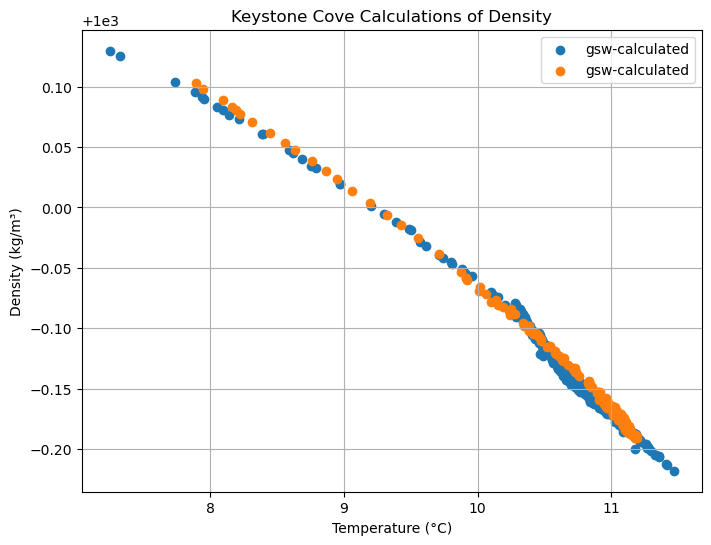

In [12]:
rho_real_key = gsw.density.rho(KEY_18['Salinity (PSS)'], KEY_18['Temperature (°C)'], KEY_18['Pressure (dbar)'])
rho_real_har = gsw.density.rho(HAR_17['Salinity (PSS)'], HAR_17['Temperature (°C)'], HAR_17['Pressure (dbar)'])

fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(HAR_17['Temperature (°C)'], rho_real_har, label='gsw-calculated')
ax.scatter(KEY_18['Temperature (°C)'], rho_real_key, label='gsw-calculated')

ax.set_title("Keystone Cove Calculations of Density")
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Density (kg/m³)')
plt.legend()
plt.grid(True)
plt.show()

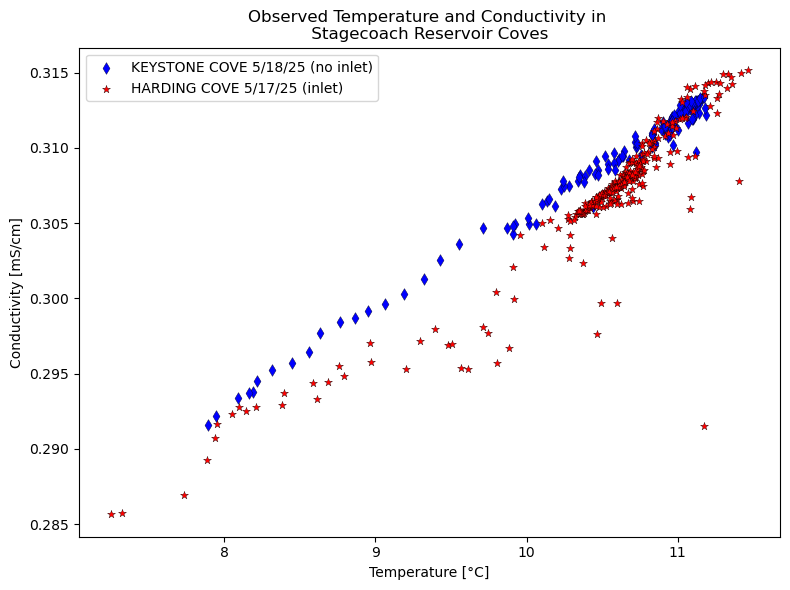

In [13]:
# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

# Plot Stagecoach data
ax.scatter(KEY_18['Temperature (°C)'], KEY_18['Conductivity (µS/cm)']/1000, c='b', 
            label='KEYSTONE COVE 5/18/25 (no inlet)', marker='d', edgecolors='k', linewidths=0.25)
ax.scatter(HAR_17['Temperature (°C)'], HAR_17['Conductivity (µS/cm)']/1000, c='r', 
           label='HARDING COVE 5/17/25 (inlet)', marker="*", edgecolors= 'k', linewidths=0.25)

# Labels and legend
ax.set_title('Observed Temperature and Conductivity in \n Stagecoach Reservoir Coves ')
#ax.set_xlim(7, 12)
ax.set_xlabel('Temperature [°C]')
#ax.set_ylim(.29, .316)
ax.set_ylabel('Conductivity [mS/cm]')
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [14]:
# Create a grid for general density surface
temp_vals = np.linspace(7, 12, 100)        # Temperature range (°C)
cond_vals = np.linspace(.284,.319, 100) # Conductivity range (mS/cm)
p_vals = np.linspace(0, 4, 100)
T, C = np.meshgrid(temp_vals, cond_vals)   # Meshgrid for surface
rho = freshwater_density(T, C)             # Compute density

# Stagecoach Reservoir values
stagecoach_temp = 11.15                             # °C
stagecoach_cond = np.linspace(307, 315, 100) / 1000    # Convert µS/cm to mS/cm
stagecoach_density = freshwater_density(stagecoach_temp, stagecoach_cond)

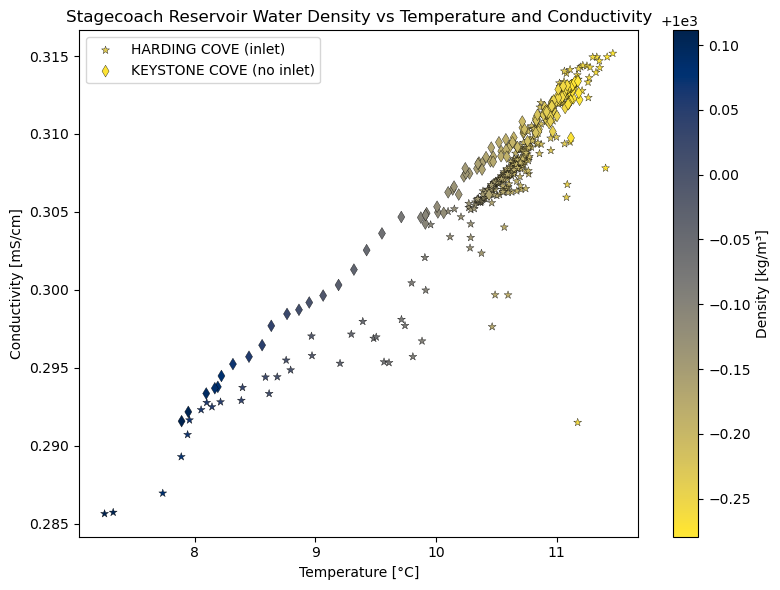

In [15]:
# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
# contour = ax.contourf(T, C, rho, levels=50, cmap="Blues")

# Plot Stagecoach data
plot = ax.scatter(HAR_17['Temperature (°C)'], HAR_17['Conductivity (µS/cm)']/1000, c=HAR_17['Density (kg/m³)'], 
           cmap='cividis_r', label='HARDING COVE (inlet)', marker="*", edgecolors= 'k', linewidths=0.25)
ax.scatter(KEY_18['Temperature (°C)'], KEY_18['Conductivity (µS/cm)']/1000, c=KEY_18['Density (kg/m³)'], 
           cmap='cividis_r', label='KEYSTONE COVE (no inlet)', marker='d', edgecolors='k', linewidths=0.25)

cbar = fig.colorbar(plot, ax=ax)
cbar.set_label('Density [kg/m³]')

# Labels and legend
ax.set_title('Stagecoach Reservoir Water Density vs Temperature and Conductivity')
#ax.set_xlim(7, 12)
ax.set_xlabel('Temperature [°C]')
#ax.set_ylim(.29, .316)
ax.set_ylabel('Conductivity [mS/cm]')
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

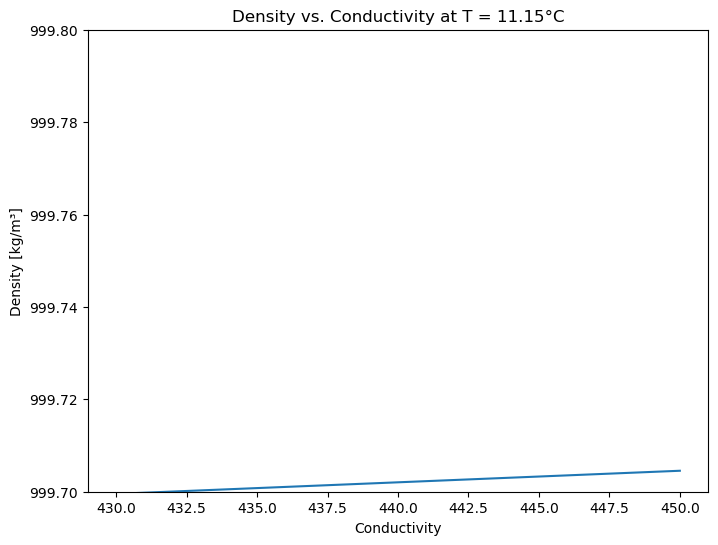

In [67]:
constant_temp = 11.15  # Scalar temp
sp_c_vals = np.linspace(430, 450, 100)
rho = freshwater_density(constant_temp, sp_c_vals)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(sp_c_vals, rho)

ax.xaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=False))
ax.xaxis.get_major_formatter().set_useOffset(False)

ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=False))
ax.yaxis.get_major_formatter().set_useOffset(False)

ax.set_ylabel('Density [kg/m³]')
ax.set_xlabel('Conductivity')

#ax.set_ylim(999.7, 1000.3)
ax.set_ylim(999.7, 999.8)

ax.set_title('Density vs. Conductivity at T = 11.15°C')
plt.show()

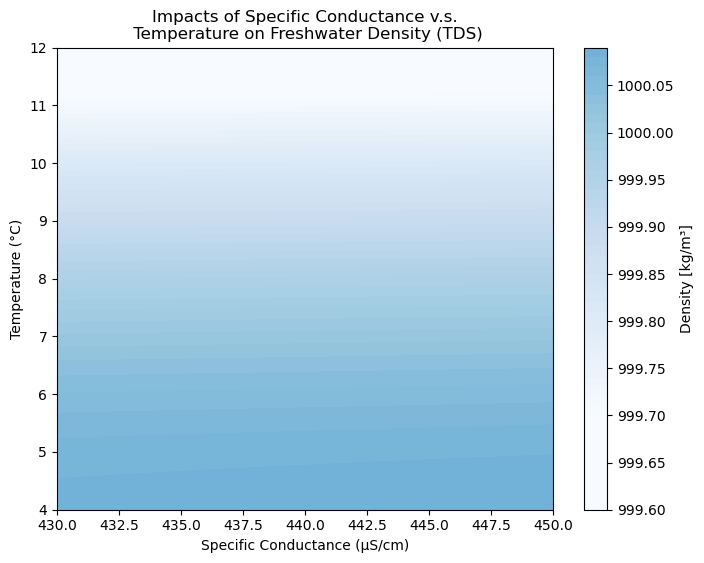

In [115]:
sp_c_vals = np.linspace(430, 450, 100)
temp_vals = np.linspace(4, 12, 100)
const_temp = 8

C, T = np.meshgrid(sp_c_vals, temp_vals)

# Compute density at each (T, C) pair
rho = freshwater_density(T, C)


# Now T is known for every (rho, C) pair — so we can contour where T == 11.15
fig, ax = plt.subplots(figsize=(8, 6))

contour = ax.contourf(C, T, rho, levels=50, cmap="Blues", vmin=999.7, vmax=1000.5)
contour_line = ax.contour(C, T, rho, levels=[const_temp], colors='black', linewidths=2)
ax.clabel(contour_line, fmt={const_temp: f'T = {const_temp}°C'}, inline=True, fontsize=10)
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label('Density [kg/m³]')


formatter = mticker.ScalarFormatter(useMathText=False)
formatter.set_scientific(False)
formatter.set_useOffset(False)
cbar.ax.yaxis.set_major_formatter(formatter)

# Axes and labels
ax.set_xlabel('Specific Conductance (µS/cm)')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Impacts of Specific Conductance v.s.\n Temperature on Freshwater Density (TDS)')


fig.savefig('freshwaterTDS-density-kgg.jpg')
plt.show()
